<a href="https://colab.research.google.com/github/nandinib1999/generate-art-using-ML/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import functools
import cv2

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

2.4.1


In [3]:
tf.executing_eagerly()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [97]:
content_path = '/content/a2cc9cfcc6602314a35e9bbcd60122be_350x350.jpg'
style_path = '/content/12830607-checkered-pattern.jpeg'

In [98]:
def imshow(img, title=None):
  op_img = np.squeeze(img, axis=0) 
  op_img = op_img.astype('uint8')
  plt.imshow(op_img)
  plt.title(title)
  plt.imshow(op_img)

In [99]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  if img.mode == "RGBA":
    img.load()
    img_2 = Image.new("RGB", img.size, (255, 255, 255))
    img_2.paste(img, mask = img.split()[3])
    img = img_2
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  return img

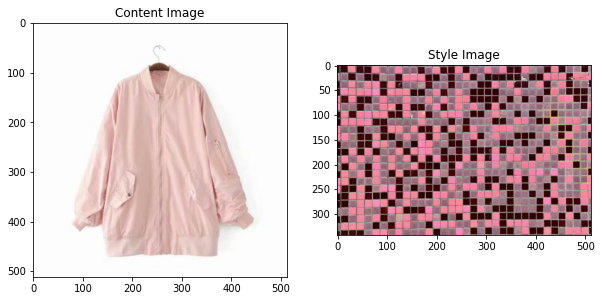

In [100]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [101]:
def process(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [102]:
def unprocess(img):
  x = img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [103]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

content_layers_count = len(content_layers)
style_layers_count = len(style_layers)

In [104]:
def get_model():
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  print(vgg.input)
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [105]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [106]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

In [107]:
def get_feature_representations(model, content_path, style_path): 
  content_image = process(content_path)
  style_image = process(style_path)
  
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  style_features = [style_layer[0] for style_layer in style_outputs[:style_layers_count]]
  content_features = [content_layer[0] for content_layer in content_outputs[style_layers_count:]]
  return style_features, content_features

In [108]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:style_layers_count]
  content_output_features = model_outputs[style_layers_count:]
  
  style_score = 0
  content_score = 0

  weight_per_style_layer = 1.0 / float(style_layers_count)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
  
  weight_per_content_layer = 1.0 / float(content_layers_count)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  loss = style_score + content_score 
  return loss, style_score, content_score

In [109]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [110]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2,
                       iteration_checkpoint = 50): 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  init_image = process(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  opt = tf.keras.optimizers.Adam(learning_rate=5)
  iter_count = 1

  best_loss, best_img = np.inf, None
   
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }

  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      best_loss = loss
      best_img = unprocess(init_image.numpy())

    if i % iteration_checkpoint == 0:
      start_time = time.time()
      
      plot_img = init_image.numpy()
      plot_img = unprocess(plot_img)
      print('Iteration: {}'.format(i+iteration_checkpoint))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
      
  return best_img, best_loss 

In [111]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=1000, iteration_checkpoint=200)

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
Iteration: 200
Total loss: 4.0244e+09, style loss: 4.0244e+09, content loss: 0.0000e+00, time: 0.0102s
Iteration: 400
Total loss: 2.1144e+07, style loss: 1.9099e+07, content loss: 2.0448e+06, time: 0.0158s
Iteration: 600
Total loss: 1.0466e+07, style loss: 8.6162e+06, content loss: 1.8495e+06, time: 0.0100s
Iteration: 800
Total loss: 7.1162e+06, style loss: 5.4134e+06, content loss: 1.7027e+06, time: 0.0104s
Iteration: 1000
Total loss: 5.5154e+06, style loss: 3.9290e+06, content loss: 1.5864e+06, time: 0.0106s
Total time: 218.7358s


In [112]:
def show_results(best_img, content_path, style_path, op_filename, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 3, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 3, 2)
  imshow(style, 'Style Image')

  plt.subplot(1, 3, 3)
  plt.imshow(best_img)
  plt.title('Output Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))
    plt.imshow(best_img)
    plt.title('Output Image')
    # plt.imsave('generate-art-using-ML/output_images/'+op_filename, best_img)
    plt.show()

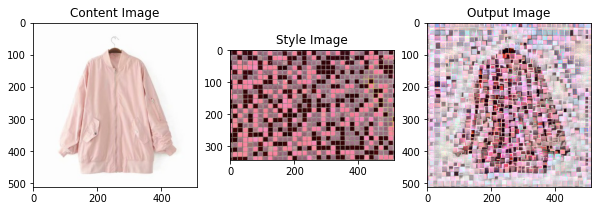

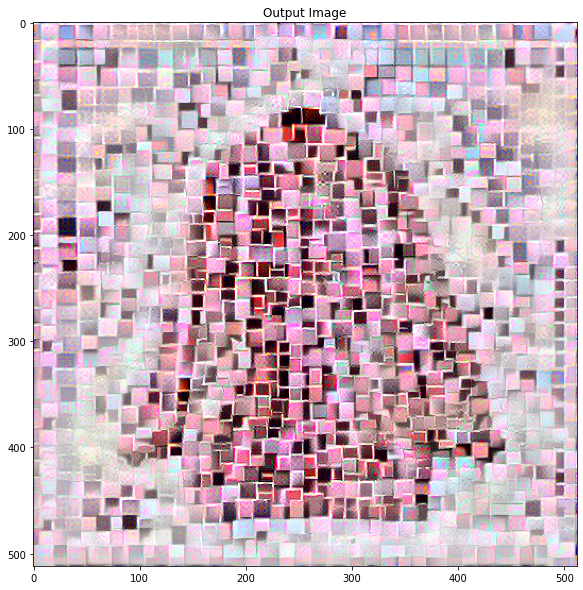

In [113]:
show_results(best, content_path, style_path, op_filename='door_mosiac.jpg')

In [114]:
import PIL
content = Image.open(content_path)
if content.mode == "RGBA":
  content.load()
  img_2 = Image.new("RGB", content.size, (255, 255, 255))
  img_2.paste(content, mask = content.split()[3])
  content = img_2
black_white = content.convert('L')
print(black_white.size)
print(black_white.mode)

(350, 350)
L


In [115]:
_, height, width, _ = load_img(content_path).shape
# im.resize(size, PIL.Image.BICUBIC)
mask = np.array(black_white.resize((width, height)))
mask.shape

(512, 512)

In [116]:
mask[mask <= 250] = 0
mask[mask > 250] = 255

In [117]:
mask = cv2.bitwise_not(mask)

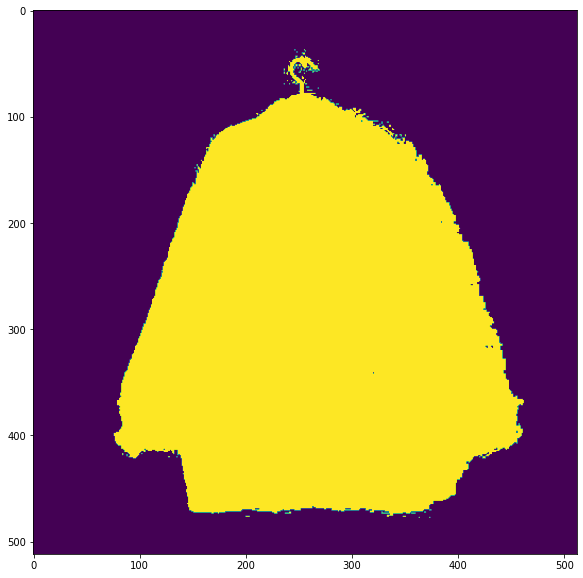

In [118]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))
ax1.imshow(mask)

In [119]:
best.shape

(512, 512, 3)

In [120]:
res = cv2.bitwise_and(best,best,mask = mask)

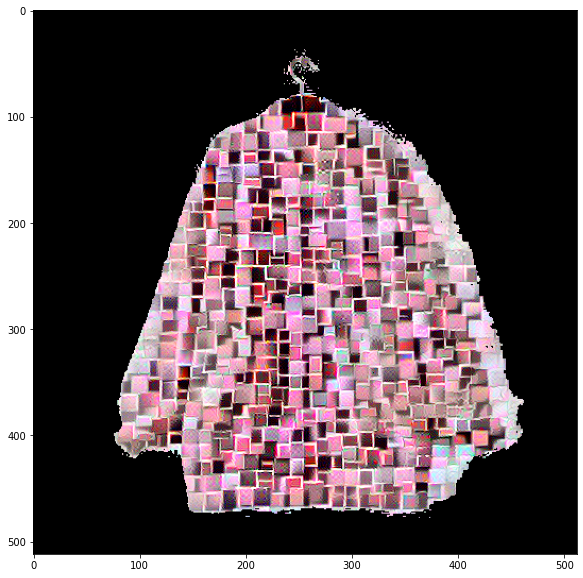

In [121]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))
ax1.imshow(res)